# Austin Animal Shelter Analysis

In [1]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
intakes = pd.read_csv('https://query.data.world/s/4dhuacn0l3k8nw0f5strehu96')
intakes.columns = ['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found_Location',
       'Intake_Type', 'IntakeCondition', 'Animal_Type', 'Sex',
       'Age', 'Breed', 'Color']

outcomes = pd.read_csv('https://query.data.world/s/1hjzqlp0xrqs5k8rfa6le49yn')
outcomes.columns = ['Animal ID', 'Name', 'DateTime', 'MonthYear', 'DOB',
       'Outcome_Type', 'Outcome_Subtype', 'Animal_Type',
       'Sex_upon_Outcome', 'Age_upon_Outcome', 'Breed', 'Color']

In [3]:
print "How many intakes and outcomes do we have?"
print len(intakes), "intakes"
print len(outcomes), "outcomes"
print "What are the columns?"
print "INTAKE: ",intakes.columns
print "OUTCOMES: ",outcomes.columns

How many intakes and outcomes do we have?
63328 intakes
63643 outcomes
What are the columns?
INTAKE:  Index([u'Animal ID', u'Name', u'DateTime', u'MonthYear', u'Found_Location',
       u'Intake_Type', u'IntakeCondition', u'Animal_Type', u'Sex', u'Age',
       u'Breed', u'Color'],
      dtype='object')
OUTCOMES:  Index([u'Animal ID', u'Name', u'DateTime', u'MonthYear', u'DOB',
       u'Outcome_Type', u'Outcome_Subtype', u'Animal_Type',
       u'Sex_upon_Outcome', u'Age_upon_Outcome', u'Breed', u'Color'],
      dtype='object')


In [4]:
# Create a new dataframe from the inner join between intakes and outcomes
records = intakes.merge(outcomes, how='inner', left_on = 'Animal ID', right_on = 'Animal ID', suffixes=('_intake', '_outcome'))
print "Resulting dataframe has", len(records), "records"

Resulting dataframe has 76977 records


## Data Cleaning
Fixing records that don't match and dropping irrelevant columns

In [5]:
print "Null DOBS:", len(records[records['DOB'].isnull()])
print "Date of birth appears to be irrelevant because every animal has a DOB even though not all animals were born in the shelter"
del records['DOB']
del records['Animal_Type_outcome']
del records['Breed_outcome']
del records['Color_outcome']
print "Animal Type, Breed and Color are all consistent across intake and outake."
print "COLUMNS: ", records.columns

Null DOBS: 0
Date of birth appears to be irrelevant because every animal has a DOB even though not all animals were born in the shelter
Animal Type, Breed and Color are all consistent across intake and outake.
COLUMNS:  Index([u'Animal ID', u'Name_intake', u'DateTime_intake', u'MonthYear_intake',
       u'Found_Location', u'Intake_Type', u'IntakeCondition',
       u'Animal_Type_intake', u'Sex', u'Age', u'Breed_intake', u'Color_intake',
       u'Name_outcome', u'DateTime_outcome', u'MonthYear_outcome',
       u'Outcome_Type', u'Outcome_Subtype', u'Sex_upon_Outcome',
       u'Age_upon_Outcome'],
      dtype='object')


## Feature Extraction

**Extract "Spayed" and "Intact" and whether or not that changed during their time in the shelter, and Gender**

In [6]:
def get_gender(val):
    try:
        val_list = val.split(' ')
        return val_list[1]
    except:
        return np.nan
def get_fixed(val):
    try:
        val_list = val.split(' ')
        return val_list[0]
    except:
        return np.nan

records['Gender'] = records['Sex'].apply(get_gender)
records['fixed_intake'] = records['Sex'].apply(get_fixed)
records['fixed_outcome'] = records['Sex_upon_Outcome'].apply(get_fixed)

records['fixed_changed'] = 0
mask = (records['fixed_intake'] == "Intact") & (records['fixed_outcome'] != "Intact")
records.ix[mask, 'fixed_changed'] = 1
mask = (records['fixed_intake'] != "Intact") & (records['fixed_outcome'] == "Intact")
records.ix[mask, 'fixed_changed'] = -1

records['fixed_changed'].value_counts()

 0    49696
 1    27141
-1      140
Name: fixed_changed, dtype: int64

** Put "Age" into buckets **

In [7]:
import re

def get_age_bucket(val):
    if re.search("day", val):
        return "Less than 1 week"
    elif re.search("week", val):
        return "1-6 weeks"
    elif re.search("[1,2,3,4,5,6] month", val):
        return "1-6 months"
    elif re.search("[7,8,9,10,11,12] month", val):
        return "7-12 months"
    elif re.search("[1,2,3] year", val):
        return "1-3 years"
    elif re.search("[4,5,6] year", val):
        return "4-6 years"
    elif re.search("year", val):
        return "7+ years"
    else:
        return "other"

records['Age_Bucket'] = records['Age'].apply(get_age_bucket)
records['Age_Bucket'].value_counts()

1-3 years           33474
1-6 months          17315
4-6 years            8758
1-6 weeks            6522
7+ years             5570
7-12 months          4118
Less than 1 week     1220
Name: Age_Bucket, dtype: int64

**Extract popular types of breeds from mix (i.e. pit bull, chihuahua)**

Retriever, Shepherd, Beagle, Terrier, Boxer, Poodle, Rottweiler, Dachshund, Chihuahua, Pit Bull

In [8]:
def get_breed(val, type):
    val = val.lower()
    if re.search(type,val):
        return 1
    else:
        return 0

types = ['retriever','shepherd','beagle','terrier','boxer','poodle','rottweiler','dachshund','chihuahua','pit_bull']
for t in types:
    records[t] = records['Breed_intake'].apply(get_breed, args=(t,))

**Difference in intake and outtake dates to see how long animals were at shelter, then bucket**

In [9]:
records['DateTime_intake'] = pd.to_datetime(records['DateTime_intake'])
records['DateTime_outcome'] = pd.to_datetime(records['DateTime_outcome'])
records['DateTime_length'] = records['DateTime_outcome'] - records['DateTime_intake']

def get_days_length(val):
    val = str(val)
    days = re.findall('\d*',val)[0]
    try:
        days = int(days)
        if days <= 7:
            return "0-7 days"
        elif days <= 21:
            return "1-3 weeks"
        elif days <= 42:
            return "3-6 weeks"
        elif days <= 84:
            return "7-12 weeks"
        elif days <= 168:
            return "12 weeks - 6 months"
        elif days <= 365:
            return "6-12 months"
        elif days <= 730:
            return "1-2 years"
        else:
            return "2+ years"
    except:
        return np.nan

records['Days_length'] = records['DateTime_length'].apply(get_days_length)
records['Days_length'].value_counts()

0-7 days               40144
1-3 weeks              11795
3-6 weeks               5930
7-12 weeks              5380
12 weeks - 6 months     2895
6-12 months             2064
1-2 years               1042
2+ years                 327
Name: Days_length, dtype: int64

### Export resulting dataframe

In [178]:
records.to_csv("all_records_with_features.csv")

# Findings

## How many animals come in as a euthanasia request and dont get euthanized?

In [28]:
mask = (records['Intake_Type'] == "Euthanasia Request") & (records['Outcome_Type'] != "Euthanasia")
print len(records[mask]), "animals"

77 animals


## How accurate are these records of intake and outtake? What discrepencies can we find?

In [11]:
mask = (records['Sex'] != records['Sex_upon_Outcome']) & ((records['Sex_upon_Outcome'] != "Spayed Female") & (records['Sex_upon_Outcome'] != "Neutered Male"))
print "Magically,", len(records[mask]), "animals were un-neutered/spayed during their time"

Magically, 144 animals were un-neutered/spayed during their time


## How many animals are spayed/neutered during their time in the shelter?

In [12]:
mask = (records['Sex'] != records['Sex_upon_Outcome']) & ((records['Sex_upon_Outcome'] == "Spayed Female") | (records['Sex_upon_Outcome'] == "Neutered Male"))
print len(records[mask]), "animals were neutered/spayed during their time"

27139 animals were neutered/spayed during their time


## What does the distribution across intake type look like and are there some intake types that are more likely to be adopted/euthanized?

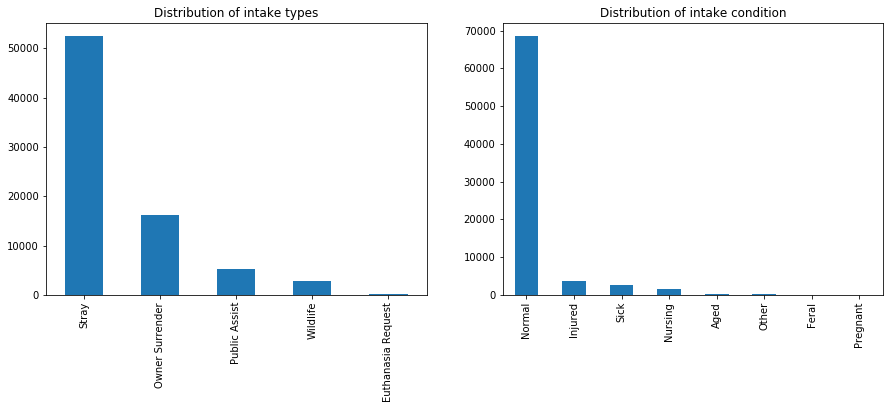

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
records['Intake_Type'].value_counts().plot(kind='bar', ax=axes[0], figsize=(15,5), title = "Distribution of intake types")
records['IntakeCondition'].value_counts().plot(kind='bar', ax=axes[1], figsize=(15,5), title = "Distribution of intake condition")

In [16]:
print "TOTAL: ", len(records)
print records['Intake_Type'].value_counts()
print records['IntakeCondition'].value_counts()

TOTAL:  76977
Stray                 52498
Owner Surrender       16123
Public Assist          5313
Wildlife               2773
Euthanasia Request      270
Name: Intake_Type, dtype: int64
Normal      68527
Injured      3581
Sick         2704
Nursing      1602
Aged          305
Other         132
Feral          78
Pregnant       48
Name: IntakeCondition, dtype: int64


In [17]:
intake_gb = records.groupby(['Intake_Type','Outcome_Type'])['Outcome_Type'].count().unstack()
intake_gb = intake_gb.T

def get_perc(val,col):
    return val / intake_gb[col].sum() * 100

intake_gb_perc = pd.DataFrame()
for col in intake_gb.columns:
    intake_gb_perc[col] = intake_gb[col].apply(get_perc, args=(col,))

intake_gb_perc

,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife
Outcome_Type,,,,,
Adoption,8.148148,62.854308,14.323358,40.934547,0.072254
Died,1.111111,0.440365,0.357613,0.718150,2.998555
Disposal,NaN,0.012405,0.451722,0.049528,7.406069
Euthanasia,71.481481,3.677976,5.383023,3.745047,87.861272
Missing,NaN,0.043416,0.075287,0.074291,0.036127
Relocate,NaN,NaN,NaN,0.005715,0.361272
Return to Owner,6.296296,8.242883,66.610201,23.828482,0.072254
Rto-Adopt,NaN,0.031012,NaN,0.034288,NaN
Transfer,12.962963,24.697637,12.798795,30.609951,1.192197


In [18]:
# What are the top two outcomes by intake type?
def find_top_two_outcomes(col):
    col = col.sort_values(ascending=False)
    print col[:2]

for col in intake_gb_perc.columns:
    find_top_two_outcomes(intake_gb_perc[col])

Outcome_Type
Euthanasia    71.481481
Transfer      12.962963
Name: Euthanasia Request, dtype: float64
Outcome_Type
Adoption    62.854308
Transfer    24.697637
Name: Owner Surrender, dtype: float64
Outcome_Type
Return to Owner    66.610201
Adoption           14.323358
Name: Public Assist, dtype: float64
Outcome_Type
Adoption    40.934547
Transfer    30.609951
Name: Stray, dtype: float64
Outcome_Type
Euthanasia    87.861272
Disposal       7.406069
Name: Wildlife, dtype: float64


## How long does the average animal spend in the shelter? Does that differ based on animal type/gender/age? Which types of animals are adopted the quickest?

Median 4 days 22:11:00 -- true average stay
Mean 15 days 02:57:04.824817 -- mean is skewed by animals with long stays
Mode 0   00:14:00
dtype: timedelta64[ns] -- most likely transfered


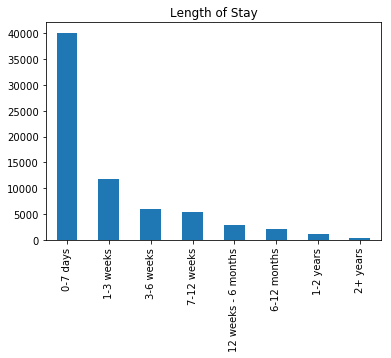

In [19]:
print "Median", records["DateTime_length"].median(), "-- true average stay"
print "Mean", records["DateTime_length"].mean(), "-- mean is skewed by animals with long stays"
print "Mode", records["DateTime_length"].mode(), "-- most likely transfered"
records['Days_length'].value_counts().plot(kind="bar", title = "Length of Stay")

### What kinds of animals are in the shelter? How does that affect length of stay?

In [20]:
records['Animal_Type_intake'].value_counts()

Dog          48097
Cat          25125
Other         3493
Bird           254
Livestock        8
Name: Animal_Type_intake, dtype: int64

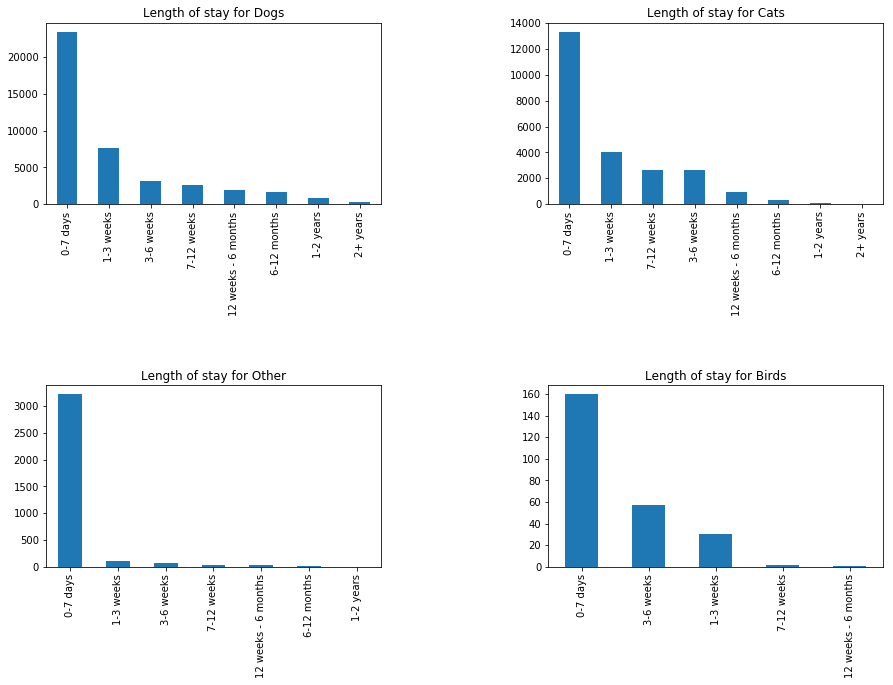

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=1, wspace = .5)

records[records["Animal_Type_intake"] == "Dog"]['Days_length'].value_counts().plot(kind='bar',ax=axes[0,0], figsize=(15,10), title = "Length of stay for Dogs")
records[records["Animal_Type_intake"] == "Cat"]['Days_length'].value_counts().plot(kind='bar',ax=axes[0,1], figsize=(15,10), title = "Length of stay for Cats")
records[records["Animal_Type_intake"] == "Other"]['Days_length'].value_counts().plot(kind='bar',ax=axes[1,0], figsize=(15,10), title = "Length of stay for Other")
records[records["Animal_Type_intake"] == "Bird"]['Days_length'].value_counts().plot(kind='bar',ax=axes[1,1], figsize=(15,10), title = "Length of stay for Birds")

### Is there a significant difference between length of stay for Dogs and Cats?
Average length of stay is slightly longer for cats.

In [22]:
from scipy.stats import ttest_ind

dog_records = records[records["Animal_Type_intake"] == "Dog"]
cat_records = records[records["Animal_Type_intake"] == "Cat"]

print "Dog Mean: ", dog_records["DateTime_length"].mean()
print "Dog Median: ", dog_records["DateTime_length"].median()
print "Cat Mean: ", cat_records["DateTime_length"].mean()
print "Cat Median: ", cat_records["DateTime_length"].median()
print ttest_ind(dog_records["DateTime_length"].astype('timedelta64[D]'), cat_records["DateTime_length"].astype('timedelta64[D]'))

Dog Mean:  14 days 01:51:08.355614
Dog Median:  5 days 01:14:00
Cat Mean:  18 days 18:45:55.140298
Cat Median:  5 days 05:26:00
Ttest_indResult(statistic=-4.4799766056687478, pvalue=7.4764007669523722e-06)


### Given an animal is adopted, is there a significant difference between length of stay for Dogs and Cats?
Average length of stay for adoptions is significantly longer for cats.

In [23]:
dog_adopted_records = dog_records[dog_records["Outcome_Type"] == "Adoption"]
cat_adopted_records = cat_records[cat_records["Outcome_Type"] == "Adoption"]

print "Dog Adopted Mean: ", dog_adopted_records["DateTime_length"].mean()
print "Dog Adopted Median: ", dog_adopted_records["DateTime_length"].median()
print "Cat Adopted Mean: ", cat_adopted_records["DateTime_length"].mean()
print "Cat Adopted Median: ", cat_adopted_records["DateTime_length"].median()
print ttest_ind(dog_adopted_records["DateTime_length"].astype('timedelta64[D]'), cat_adopted_records["DateTime_length"].astype('timedelta64[D]'))

Dog Adopted Mean:  21 days 12:08:31.021870
Dog Adopted Median:  7 days 01:15:00
Cat Adopted Mean:  32 days 03:13:04.975691
Cat Adopted Median:  22 days 12:13:30
Ttest_indResult(statistic=-7.0348944575730084, pvalue=2.0339295058256773e-12)


### Given an animal is adopted, is there a significant difference between length of stay for Female vs Male dogs and cats?
Not a significant difference between Dogs, almost a significant difference between cats. Male animals are adopted faster across the board.

In [24]:
male_dog_adopted_records = dog_adopted_records[dog_adopted_records["Gender"] == "Male"]
female_dog_adopted_records = dog_adopted_records[dog_adopted_records["Gender"] == "Female"]
male_cat_adopted_records = cat_adopted_records[cat_adopted_records["Gender"] == "Male"]
female_cat_adopted_records = cat_adopted_records[cat_adopted_records["Gender"] == "Female"]

print "Male Dog Adopted Mean: ", male_dog_adopted_records["DateTime_length"].mean()
print "Female Dog Adopted Mean: ", female_dog_adopted_records["DateTime_length"].mean()
print "Male Cat Adopted Mean: ", male_cat_adopted_records["DateTime_length"].mean()
print "Female Cat Adopted Mean: ", female_cat_adopted_records["DateTime_length"].mean()

print "Male vs Female Dog", ttest_ind(male_dog_adopted_records["DateTime_length"].astype('timedelta64[D]'), female_dog_adopted_records["DateTime_length"].astype('timedelta64[D]'))
print "Male vs Female Cat", ttest_ind(male_cat_adopted_records["DateTime_length"].astype('timedelta64[D]'), female_cat_adopted_records["DateTime_length"].astype('timedelta64[D]'))

Male Dog Adopted Mean:  20 days 18:29:46.794232
Female Dog Adopted Mean:  22 days 06:44:19.474338
Male Cat Adopted Mean:  30 days 09:33:18.362865
Female Cat Adopted Mean:  33 days 18:39:58.953298
Male vs Female Dog Ttest_indResult(statistic=-0.80597657113653964, pvalue=0.42026527739021102)
Male vs Female Cat Ttest_indResult(statistic=-1.6635290900407023, pvalue=0.096235876580116703)


### Given an animal is adopted, is there a significant difference between length of stay based on Age for dogs and cats?

In [83]:
print "DOGS"
dog_adopted_records["DateTime_length_int"] = dog_adopted_records["DateTime_length"].astype('timedelta64[D]')
dog_adopted_records_gb_age = dog_adopted_records.groupby(["Age_Bucket"])["DateTime_length_int"].mean()
print dog_adopted_records_gb_age

print "\nCATS"
cat_adopted_records["DateTime_length_int"] = cat_adopted_records["DateTime_length"].astype('timedelta64[D]')
cat_adopted_records_gb_age = cat_adopted_records.groupby(["Age_Bucket"])["DateTime_length_int"].mean()
print cat_adopted_records_gb_age

DOGS
Age_Bucket
1-3 years           14.823166
1-6 months          22.161159
1-6 weeks           49.776699
4-6 years           28.748453
7+ years            47.360616
7-12 months         19.501130
Less than 1 week    70.900621
Name: DateTime_length_int, dtype: float64

CATS
Age_Bucket
1-3 years           13.756214
1-6 months          26.942706
1-6 weeks           67.023282
4-6 years           34.409346
7+ years            34.990637
7-12 months         -1.301136
Less than 1 week    86.952000
Name: DateTime_length_int, dtype: float64


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Are there certain months that people tend to make more adoptions on? What about certain days of the week (weekends)?
0 is Monday, 6 is Sunday

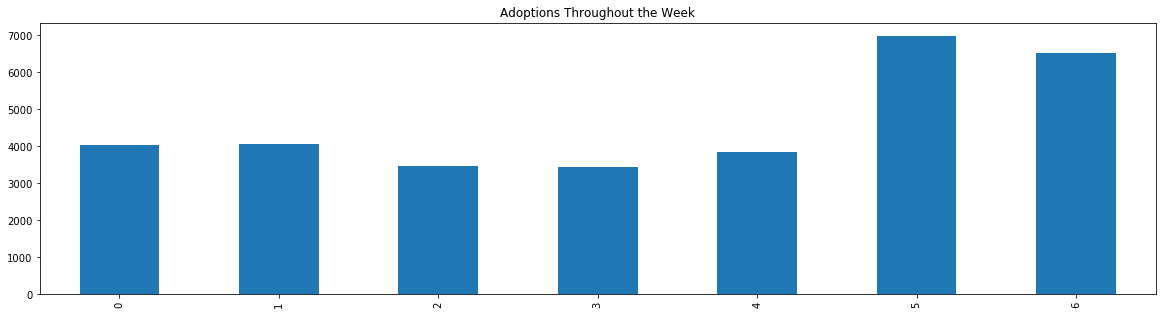

In [175]:
records[records['Outcome_Type'] == "Adoption"]['DateTime_outcome'].dt.dayofweek.value_counts().sort_index().plot(kind="bar", figsize=(20,5), title = "Adoptions Throughout the Week")

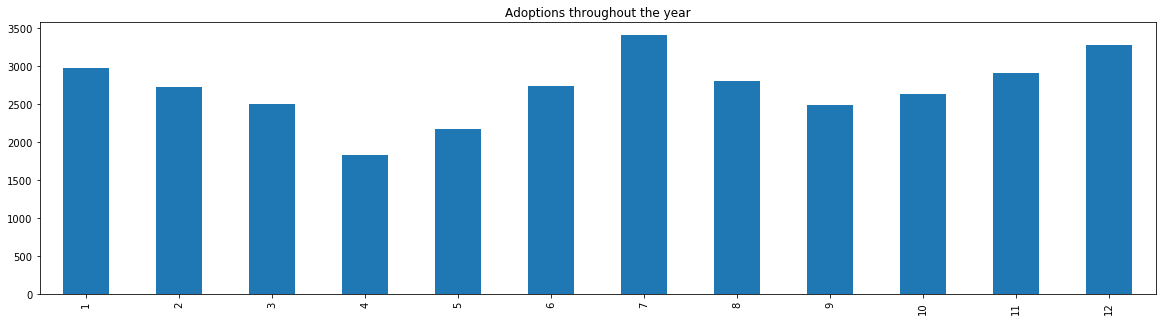

In [177]:
records[records['Outcome_Type'] == "Adoption"]['DateTime_outcome'].dt.month.value_counts().sort_index().plot(kind='bar', figsize=(20,5), title = "Adoptions throughout the year")

## How does likelihood of being adopted vs euthanized vs return to owner vs transfer change based on animal type, gender, and age?

### What is the likelihood of outcomes based on Dog vs Cat?

In [100]:
print "DOGS"
dog_records_outcome_gb = dog_records.groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(dog_records_outcome_gb["Adoption"]) / float(dog_records_outcome_gb.sum()) * 100, "% adopted"
print float(dog_records_outcome_gb["Euthanasia"]) / float(dog_records_outcome_gb.sum()) * 100, "% euthanized"
print float(dog_records_outcome_gb["Return to Owner"]) / float(dog_records_outcome_gb.sum()) * 100, "% return to owner"
print float(dog_records_outcome_gb["Transfer"]) / float(dog_records_outcome_gb.sum()) * 100, "% transferred"

print "\nCATS"
cat_records_outcome_gb = cat_records.groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(cat_records_outcome_gb["Adoption"]) / float(cat_records_outcome_gb.sum()) * 100, "% adopted"
print float(cat_records_outcome_gb["Euthanasia"]) / float(cat_records_outcome_gb.sum()) * 100, "% euthanized"
print float(cat_records_outcome_gb["Return to Owner"]) / float(cat_records_outcome_gb.sum()) * 100, "% return to owner"
print float(cat_records_outcome_gb["Transfer"]) / float(cat_records_outcome_gb.sum()) * 100, "% transferred"

DOGS
44.6814703925 % adopted
3.33291749834 % euthanized
33.3083832335 % return to owner
18.3092149035 % transferred

CATS
42.5728387199 % adopted
4.98328291673 % euthanized
5.32956535584 % return to owner
45.6774398981 % transferred


### What is the likelihood of outcomes based on gender?

In [111]:
print "MALE DOGS"
male_dog_records_outcome_gb = dog_records[dog_records['Gender'] == "Male"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(male_dog_records_outcome_gb["Adoption"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% adopted"
print float(male_dog_records_outcome_gb["Euthanasia"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% euthanized"
print float(male_dog_records_outcome_gb["Return to Owner"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% return to owner"
print float(male_dog_records_outcome_gb["Transfer"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% transferred"

print "\nFEMALE DOGS"
female_dog_records_outcome_gb = dog_records[dog_records['Gender'] == "Female"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(female_dog_records_outcome_gb["Adoption"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% adopted"
print float(female_dog_records_outcome_gb["Euthanasia"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% euthanized"
print float(female_dog_records_outcome_gb["Return to Owner"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% return to owner"
print float(female_dog_records_outcome_gb["Transfer"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% transferred"

print "\nMALE CATS"
male_cat_records_outcome_gb = cat_records[cat_records['Gender'] == "Male"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(male_cat_records_outcome_gb["Adoption"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% adopted"
print float(male_cat_records_outcome_gb["Euthanasia"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% euthanized"
print float(male_cat_records_outcome_gb["Return to Owner"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% return to owner"
print float(male_cat_records_outcome_gb["Transfer"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% transferred"

print "\nFEMALE CATS"
female_cat_records_outcome_gb = cat_records[cat_records['Gender'] == "Female"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(female_cat_records_outcome_gb["Adoption"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% adopted"
print float(female_cat_records_outcome_gb["Euthanasia"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% euthanized"
print float(female_cat_records_outcome_gb["Return to Owner"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% return to owner"
print float(female_cat_records_outcome_gb["Transfer"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% transferred"

MALE DOGS
42.2555180871 % adopted
3.59058859595 % euthanized
36.0783261803 % return to owner
17.7306866953 % transferred

FEMALE DOGS
47.9316505566 % adopted
2.95478491914 % euthanized
30.2029410417 % return to owner
18.5807870264 % transferred

MALE CATS
46.0487804878 % adopted
5.34811529933 % euthanized
6.74057649667 % return to owner
40.3902439024 % transferred

FEMALE CATS
47.5133828354 % adopted
4.07528924193 % euthanized
4.89552754274 % return to owner
42.2897599724 % transferred


### What is the likelihood of outcome based on age?

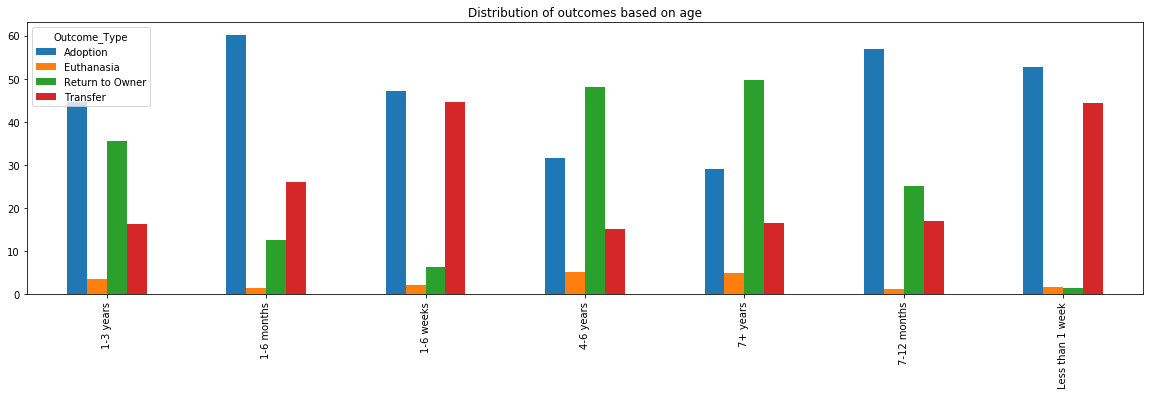

In [155]:
dog_records_outcome_age_gb = dog_records.groupby(['Outcome_Type','Age_Bucket'])['Age_Bucket'].count().unstack()
# Drop outcomes we're not interested in
dog_records_outcome_age_gb = dog_records_outcome_age_gb.drop(dog_records_outcome_age_gb.index[[1,2,4,6]])

# Transform into a percentage
def get_perc_outcome(val,col):
    return float(val) / float(dog_records_outcome_age_gb[col].sum()) * 100

perc_dog_records_outcome_age_gb = pd.DataFrame()
for col in dog_records_outcome_age_gb.columns:
    perc_dog_records_outcome_age_gb[col] = dog_records_outcome_age_gb[col].apply(get_perc_outcome, args=(col,))

perc_dog_records_outcome_age_gb = perc_dog_records_outcome_age_gb.T
perc_dog_records_outcome_age_gb.plot(kind="bar", figsize=(20,5), title = "Distribution of outcomes based on age (%)")

## General Knowledge:

In [13]:
# What do the outcome subtypes mean? How do those match up to outcomes?
records.groupby(by=['Outcome_Type','Outcome_Subtype'])['Animal ID'].count()

Outcome_Type  Outcome_Subtype    
Adoption      Barn                       1
              Foster                  4786
              Offsite                  325
Died          At Vet                    28
              Enroute                   30
              In Foster                116
              In Kennel                280
              In Surgery                11
Euthanasia    Aggressive               620
              At Vet                     4
              Behavior                 144
              Court/Investigation       28
              Medical                  217
              Rabies Risk             2062
              Suffering               2208
              Underage                  26
Missing       In Foster                 15
              In Kennel                  7
              Possible Theft            16
Transfer      Barn                       2
              Partner                17367
              SCRP                    3430
Name: Animal ID, dty